In [2]:
import gzip
import json
import numpy as np
from scipy.misc import logsumexp
import matplotlib.pyplot as plt

In [50]:
grids_path = 'runs/hawkins_big_l2_heldout_nodupes_tunegrid/grids.0.jsons.gz'
with gzip.open(grids_path, 'rb') as infile:
    grids = [json.loads(line.strip()) for line in infile]

In [51]:
len(grids)

3500

In [52]:
data_path = 'runs/hawkins_big_l2_heldout_nodupes_tunegrid/data.eval.jsons'
with open(data_path, 'r') as infile:
    insts = [json.loads(line.strip()) for line in infile]
gold_outputs = np.array([inst['output'] for inst in insts])[:len(grids)]

In [53]:
l0_biggrid = np.array([[np.array(ss['L0']).T for ss in grid['sets']] for grid in grids])

In [54]:
all_ss = l0_biggrid.shape[1]
l0_biggrid.shape

(3500, 8, 25, 3)

In [55]:
def compute_l2(l0, alpha):
    l0_a = l0 * alpha
    s1 = l0_a - logsumexp(l0_a, axis=2, keepdims=True)
    return s1 - logsumexp(s1, axis=3, keepdims=True)

def compute_final(l0, l2, base_weight):
    blended = ((1 - base_weight) * l2 + base_weight * l0)[:, :, 0, :]
    final = logsumexp(blended, axis=1) - np.log(blended.shape[1])
    return final - logsumexp(final, axis=1, keepdims=True)

def accuracy(golds, final):
    return np.sum(np.argmax(final, axis=1) == golds) * 1.0 / len(golds)

def perplexity(golds, final):
    return np.exp(-np.mean(final[np.arange(len(golds)), golds]))

In [56]:
l2 = compute_l2(l0_biggrid, alpha=0.5)
final = compute_final(l0_biggrid, l2, base_weight=0.1)
perplexity(gold_outputs, final)

1.5389679180345084

In [57]:
accuracy(gold_outputs, final)

0.82371428571428573

In [65]:
EXA = [0.55, 0.65]
EXA.reverse()
ALPHAS = np.arange(EXA[1], EXA[0], 0.001)
EXB = [-0.35, -0.25]
BWS = np.arange(EXB[0], EXB[1], 0.001)

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100
6 sample sets
best accuracy:   0.82571 at alpha=0.64700, bw=-0.28200
best perplexity: 1.52969 at alpha=0.58500, bw=-0.25900


/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log


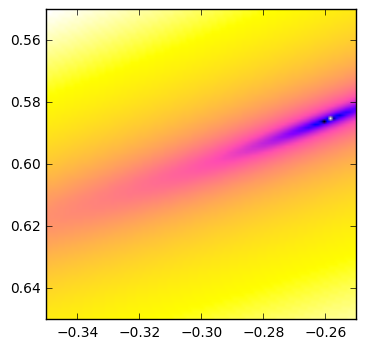

In [67]:
for num_ss in [6]:  # range(1, l0_biggrid.shape[1] + 1):
    l0_ss = l0_biggrid[:, :num_ss, :, :]
    perps = []
    accs = []
    for i, alpha in enumerate(ALPHAS):
        if i % 10 == 0:
            print('{} of {}'.format(i, len(ALPHAS)))
        l2 = compute_l2(l0_ss, alpha)
        perps_alpha = []
        accs_alpha = []
        for base_weight in BWS:
            final = compute_final(l0_ss, l2, base_weight)
            perps_alpha.append(perplexity(gold_outputs, final))
            accs_alpha.append(accuracy(gold_outputs, final))
        perps.append(perps_alpha)
        accs.append(accs_alpha)

    perps_a = np.array(perps)
    perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
    alpha_idx, base_idx = np.unravel_index(np.nanargmin(perps), np.array(perps).shape)
    p_coord = (ALPHAS[alpha_idx], BWS[base_idx])
    alpha_idx, base_idx = np.unravel_index(np.nanargmin(accs), np.array(accs).shape)
    a_coord = (ALPHAS[alpha_idx], BWS[base_idx])
    print('{} sample sets'.format(num_ss))
    print('best accuracy:   {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.max(accs), a_coord[0], a_coord[1]))
    print('best perplexity: {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.min(perps_a), p_coord[0], p_coord[1]))
    
    acc_limit = np.median(accs)
    perps_limit = np.min(perps_a)
    
    plt.imshow(np.maximum(np.array(accs), acc_limit) * 0.0 + np.log(np.minimum(perps, 3.0) - perps_limit),
               extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
    plt.show()

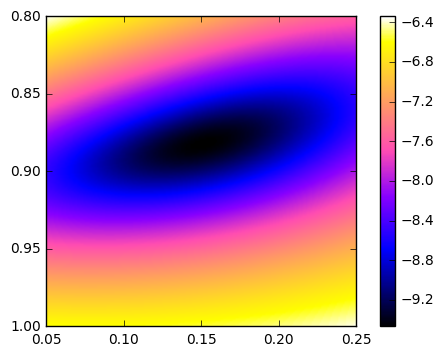

In [107]:
plt.imshow(np.log(np.minimum(perps, 3.0) - 1.239), extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
plt.colorbar()
plt.show()

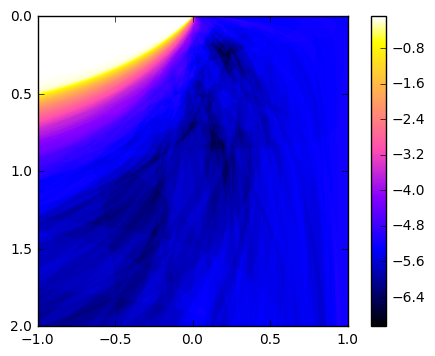

In [19]:
plt.imshow(np.log(0.924 - np.array(accs)), extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
plt.colorbar()
plt.show()

In [22]:
save_image(np.log(0.924 - np.array(accs)), '~/halo.png')

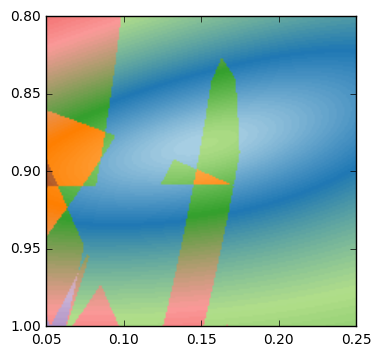

In [109]:
plt.imshow(np.maximum(np.array(accs), 0.921) * 20000.0 + np.log(np.minimum(perps, 3.0) - 1.239), extent=EXB + EXA, aspect=1.0, cmap='Paired')
plt.show()

In [100]:
good_accs = np.where(np.array(accs) - 0.92114285714285715 >= 0.0001)
good_accs

(array([ 61,  62,  62, ..., 199, 199, 199]),
 array([ 0,  0,  1, ..., 10, 11, 12]))

In [101]:
good_idx = np.nanargmin(np.array(perps)[good_accs])
alpha_idx, base_idx = (good_accs[0][good_idx], good_accs[1][good_idx])

In [102]:
perps[alpha_idx][base_idx]

1.2391047686551999

In [103]:
(ALPHAS[alpha_idx], BWS[base_idx])

(0.89900000000000013, 0.14700000000000008)

In [104]:
alpha_idx, base_idx = np.unravel_index(np.nanargmin(perps), np.array(perps).shape)
print((ALPHAS[alpha_idx], BWS[base_idx]))
print(accs[alpha_idx][base_idx])
print(perps[alpha_idx][base_idx])

(0.88200000000000012, 0.15200000000000008)
0.921142857143
1.23907727227


In [105]:
alpha_idx, base_idx = np.unravel_index(np.nanargmax(accs), np.array(accs).shape)
print((ALPHAS[alpha_idx], BWS[base_idx]))
print(accs[alpha_idx][base_idx])
print(perps[alpha_idx][base_idx])

(0.89300000000000013, 0.050000000000000003)
0.921714285714
1.23921553943


/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in add


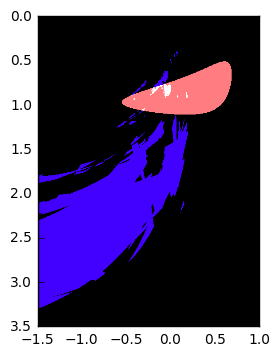

In [182]:
EXA = [3.5, 0.0]
ALPHAS = np.arange(EXA[1], EXA[0], 0.005)
EXB = [-1.5, 1.0]
BWS = np.arange(EXB[0], EXB[1], 0.005)

l0_ss = l0_biggrid[:, :1, :, :]
perps = []
accs = []
for alpha in ALPHAS:
    l2 = compute_l2(l0_ss, alpha)
    perps_alpha = []
    accs_alpha = []
    for base_weight in BWS:
        final = compute_final(l0_ss, l2, base_weight)
        perps_alpha.append(perplexity(gold_outputs, final))
        accs_alpha.append(accuracy(gold_outputs, final))
    perps.append(perps_alpha)
    accs.append(accs_alpha)

perps_a = np.array(perps)
perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
'''
alpha_idx, base_idx = np.unravel_index(np.nanargmin(perps), np.array(perps).shape)
p_coord = (ALPHAS[alpha_idx], BWS[base_idx])
alpha_idx, base_idx = np.unravel_index(np.nanargmin(accs), np.array(accs).shape)
a_coord = (ALPHAS[alpha_idx], BWS[base_idx])
print('{} sample sets'.format(num_ss))
print('best accuracy:   {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.max(accs), a_coord[0], a_coord[1]))
print('best perplexity: {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.min(perps_a), p_coord[0], p_coord[1]))
'''

acc_limit = (np.median(accs) + np.max(accs)) / 2.0
perps_limit = np.min(perps_a)

plt.imshow((np.array(accs) > acc_limit) + (perps_a < perps_limit + 0.005) * 2.0,
           extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
plt.show()

In [21]:
def save_image(data, path):
    import os
    fig = plt.figure(frameon=False)
    fig.set_size_inches(data.shape[1] / 96., data.shape[0] / 96.)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data,
              aspect=1.0, cmap='gnuplot2')
    plt.savefig(os.path.expanduser(path), dpi=96)

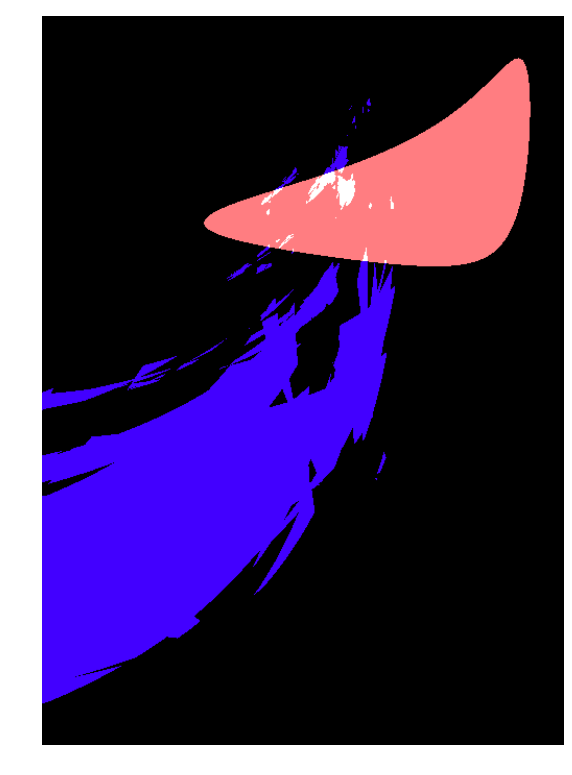

In [204]:
pct = 0.5
acc_limit = (1.0 - pct) * np.median(accs) + pct * np.max(accs)
data = (np.array(accs)[:, :] > acc_limit) + (perps_a < perps_limit + 0.008)[:, :] * 2.0
save_image(data, '~/boomerang.png')